***
## [October 2018] - Understanding peaks in measured undulator spectrum
### Abstract:
Undulator spectra are taken after the monochromator (obviously, because they are energy resolved). They show many more peaks than SPECTRA calculations suggest should be there.

We can show that these arise from 'folding down' of higher order features by the monochromator (i.e. the monochromator tuned to 20eV lets through whatever is at 20,40,60,80eV... in the undulator spectra.

This also illustrates the point of a quasi-periodic undulator - there is relatively little spectral weight folded down on top of the fundamental peak. 

***

In [5]:
from BLOCH_beamline import *
data_folder = Path('Data/')

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

### Measurement details

|Electrometer channel|Measurement|
|-|-|
| b110a_ctl_em02_ch03 |Current at the M4 photodiode (M4 diagnostic position 78.98)|
| b110a_ctl_em02_ch01 |Gold mesh (M4 diagnostic position 137)|
| b110a_ctl_em03_ch01 | Exit slit left baffle |
| b110a_ctl_em03_ch02 | Exit slit right baffle |

|Beamline parameter | Setting |
|-|-|
| Ring current | 200mA|
| EPU (gap, phase) | (19, 0)|
| F.E. mm(1x,2x, 1y, 2y) | (-2.49, -5.58, -3.2, -5) |
| F.E. gap (x,y) | (-8.07, -8.2) |
| F.E. offset (x,y) | (1.55, 0.9) |
| M1 (pitch,lateral) | (-1760\*, 1800) |
| Mono baffle gap (h, v) |(15,15)|
| Mono baffle offset (h, v) | (-0.2,0.7)|
| M3 baffle gap (h, v) | (50mm,19mm)|
| Exit slit gap (h, v) | (130um, 1200um) |
| M4 baffle gap (h, v) | (50mm,19mm)|

\* Feedback loop on

| Filename | Scan | EPU gap | hv range | Detector |
|-|-|-|-|-|
|undu_mono_scan4| 1374 | 20 | 9-50 |Gold mesh|
|undu_mono_scan4| 1375 | 20 | 9-50 |Photodiode| 



***
## Calculation details

| Parameter | Value |
|-|-|
|Program | SPECTRA 10.1|
|Mode | Near field>energy dependence>partial flux|
|Field data|Gap50_HP_BxBy_Scan7c.txt|
|Parameter file |84.prm\*|

\*current reduced to 200mA


| Folder | Filename | $\Delta$qx,y (mrad) | acceptance (1$\sigma$=0.15mrad) | qx,y (mrad) |
|-|-|-|-|-|
|root| 20mm_1sigma_10_1000.dc0 | 0.075 | 0.5 |0 |

***

In [6]:
calculation_folder = Path('SPECTRA_calculations')
calculation = loadSPECTRACalc(calculation_folder/"20mm_1sigma_10_1000.dc0")

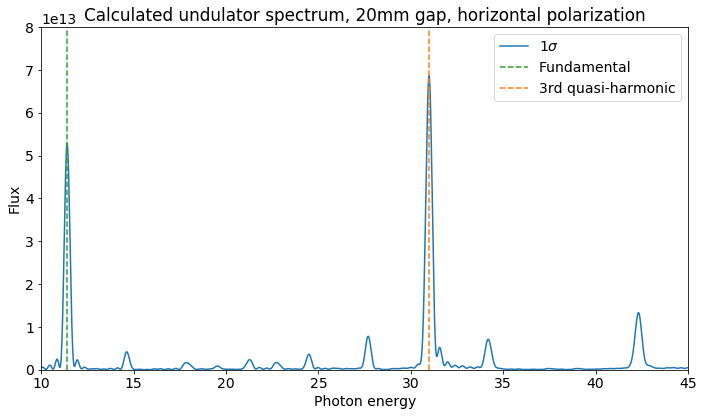

In [7]:
fig=plt.figure(figsize=(10,6))
plt.plot(calculation['mono_energy'],calculation['flux'],label="1$\sigma$")
plt.plot([11.4,11.4],[0,8e13],linestyle='--',color='tab:green',label="Fundamental")
plt.plot([31,31],[0,8e13],linestyle='--',color='tab:orange',label="3rd quasi-harmonic")
plt.ylabel('Flux')
plt.xlabel('Photon energy')
plt.title("Calculated undulator spectrum, 20mm gap, horizontal polarization")
plt.xlim([10,45])
plt.ylim([0,8e13])
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
dataFile=data_folder/'undu_mono_scan4.h5'

goldMesh = HDF5loadscan(dataFile,1374)
goldMesh['mono_energy_calibrated']=[n*(0.942) for n in calibrateMonoEnergy(goldMesh['mono_energy'])]
goldMesh['Current'] = [((ii)/1000) for ii in goldMesh['b110a_ctl_em02_ch01']]

photoDiode = HDF5loadscan(dataFile,1375)
photoDiode['mono_energy_calibrated']=[n*(0.942) for n in calibrateMonoEnergy(photoDiode['mono_energy'])]
photoDiode['Current'] = [((ii*-1)/1000) for ii in photoDiode['b110a_ctl_em02_ch03']]
photoDiode['flux'] = [currentToFlux(I,hv) for I,hv in zip(photoDiode['Current'],photoDiode['mono_energy_calibrated'])]


Implementing mono calibration according to Mats, May 2018
Implementing mono calibration according to Mats, May 2018


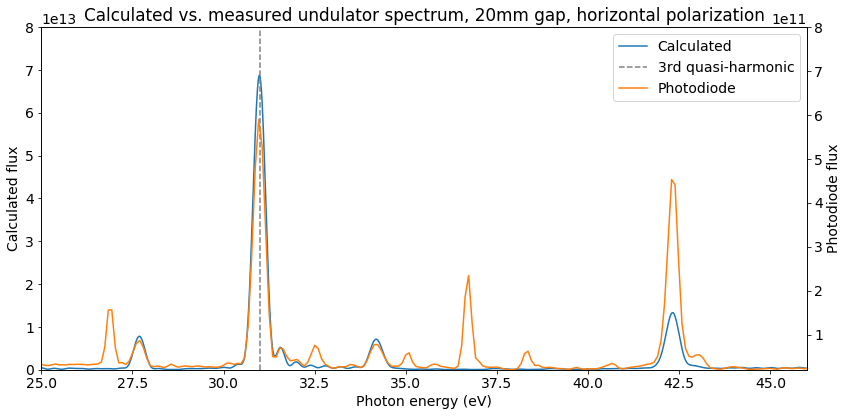

In [9]:
fig=plt.figure(figsize=(12,6))

ax1 = plt.gca()
ax2 = ax1.twinx()

trace1=ax1.plot(calculation['mono_energy'],calculation['flux'],label="Calculated")
trace2=ax1.plot([31,31],[0,8e13],linestyle='--',color='grey',label="3rd quasi-harmonic")
ax1.set_ylabel('Calculated flux')
ax1.set_ylim([0,8e13])
ax1.set_xlim([25,46])

trace3=ax2.plot(photoDiode['mono_energy_calibrated'],photoDiode['flux'],color='tab:orange',label='Photodiode')
ax2.set_ylabel('Photodiode flux')
ax2.set_ylim([2e10,8e11])

traces = trace1 + trace2 + trace3

labels = [trace.get_label() for trace in traces]
ax2.legend(traces,labels)
ax1.set_xlabel('Photon energy (eV)')

plt.title("Calculated vs. measured undulator spectrum, 20mm gap, horizontal polarization")
plt.tight_layout()
plt.show()

Here we see a good example: what is the prominent peak in the measured data at 36.7eV? That part of the undulator spectrum is totally flat.

(*Notice that I hand-rescaled the experimental energy axis to force agreement of the fundamental position*)

(*I'm also ignoring the fundamental peak, simply because the experimental data in this particular measurement had a not-normal background below 25eV*)

### Monochromator folding

The most probably answer is that there a feature at (36.7\*n)eV in the undulator spectra, and the monochromator has folded it down. This is the same effect as 'higher order contamination', except now we don't really care about it because at this gap we'll be using the fundamental at 11.4eV.

We can simulate this from the calculated undulator spectra, even separating out by orders:


In [10]:
dataDict = calculation
dataDict['current_higherOrders']=[float('NaN') for n in dataDict['flux']]
dataDict['current_2ndOrder']=[float('NaN') for n in dataDict['flux']]
dataDict['current_3rdOrder']=[float('NaN') for n in dataDict['flux']]
dataDict['current_4thOrder']=[float('NaN') for n in dataDict['flux']]
dataDict['current_5thOrder']=[float('NaN') for n in dataDict['flux']]

dataDict['currentFromFlux'] = [fluxToCurrent(f,hv) for f,hv in zip(dataDict['flux'],dataDict['mono_energy'])]

monoOffset=dataDict['mono_energy'][0]
monoStep=dataDict['mono_energy'][1]-dataDict['mono_energy'][0]

higherOrders = [1,2,3,4,5]
higherOrderAttenuation = [1/1,1/(2*2),1/(5),1/(5),1/(5)]

monoEnergy=dataDict['mono_energy']

reachedMaximumEnergy=False

for index,energy in enumerate(monoEnergy):
    higherOrderIndex = [(round(((energy*n)-monoOffset)/monoStep)) for n in higherOrders ]
    try:
        dataDict['current_higherOrders'][index]= sum([(dataDict['currentFromFlux'][index]*(attenuation)) for attenuation,index in zip(higherOrderAttenuation,higherOrderIndex) ])
        dataDict['current_2ndOrder'][index]= dataDict['currentFromFlux'][higherOrderIndex[1]]*higherOrderAttenuation[1]
        dataDict['current_3rdOrder'][index]= dataDict['currentFromFlux'][higherOrderIndex[2]]*higherOrderAttenuation[2]
        dataDict['current_4thOrder'][index]= dataDict['currentFromFlux'][higherOrderIndex[3]]*higherOrderAttenuation[3]
        dataDict['current_5thOrder'][index]= dataDict['currentFromFlux'][higherOrderIndex[4]]*higherOrderAttenuation[4]

    except:
        if reachedMaximumEnergy==False:
            print("Calculated spectra not long enough! Have to stop at",energy)
            reachedMaximumEnergy=True
        

Calculated spectra not long enough! Have to stop at 200.01


Important to notice here is that the *higherOrderAttenuation* factors are completely made up. It will depend on the energy-dependent reflectivity of the grating at whatever angle it happens to be at.

In the following we should therefore **not** assign too much significance to the *intensity* of the simulated peaks.

In [11]:
dataDict['current_2ndOrder_toFlux'] = [currentToFlux(I,hv) for I,hv in zip(dataDict['current_2ndOrder'],dataDict['mono_energy'])]
dataDict['current_3rdOrder_toFlux'] = [currentToFlux(I,hv) for I,hv in zip(dataDict['current_3rdOrder'],dataDict['mono_energy'])]
dataDict['current_4thOrder_toFlux'] = [currentToFlux(I,hv) for I,hv in zip(dataDict['current_4thOrder'],dataDict['mono_energy'])]
dataDict['current_5thOrder_toFlux'] = [currentToFlux(I,hv) for I,hv in zip(dataDict['current_5thOrder'],dataDict['mono_energy'])]

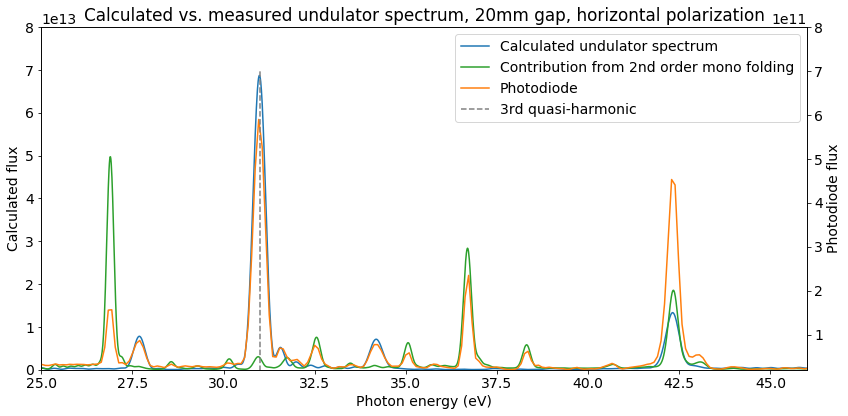

In [12]:
fig=plt.figure(figsize=(12,6))

ax1 = plt.gca()
ax2 = ax1.twinx()

trace1=ax1.plot(calculation['mono_energy'],calculation['flux'],color='tab:blue',label="Calculated undulator spectrum")
trace2=ax1.plot(calculation['mono_energy'],calculation['current_2ndOrder_toFlux'],color='tab:green',label="Contribution from 2nd order mono folding")
ax1.set_ylabel('Calculated flux')
ax1.set_ylim([0,8e13])
ax1.set_xlim([25,46])

trace3=ax2.plot(photoDiode['mono_energy_calibrated'],photoDiode['flux'],color='tab:orange',label='Photodiode')
trace4=ax2.plot([31,31],[0,7e11],linestyle='--',color='grey',label="3rd quasi-harmonic")
ax2.set_ylabel('Photodiode flux')
ax2.set_ylim([2e10,8e11])

traces = trace1 + trace2+trace3+trace4
labels = [trace.get_label() for trace in traces]
ax2.legend(traces,labels)
ax1.set_xlabel('Photon energy (eV)')
plt.title("Calculated vs. measured undulator spectrum, 20mm gap, horizontal polarization")
plt.tight_layout()
plt.show()

There you have it: 5 of the unexpected peaks in this part of the spectrum can be explained by second-order folding by the monochromator. Since the photodiode is not energy-resolved, it can't tell the difference between 36.7eV and 73.4eV photons when the monochromator is letting both through.

It's worth taking a look specifically at the fundamental and 3rd quasi-harmonic peaks, i.e. the ones we would ever actually use. Here the same analysis shows why a quasi-periodic EPU is nice to have: there are very few folded-in higher order peaks. 

(Again remember that the intensity here comes via completely made-up attenuation factors)

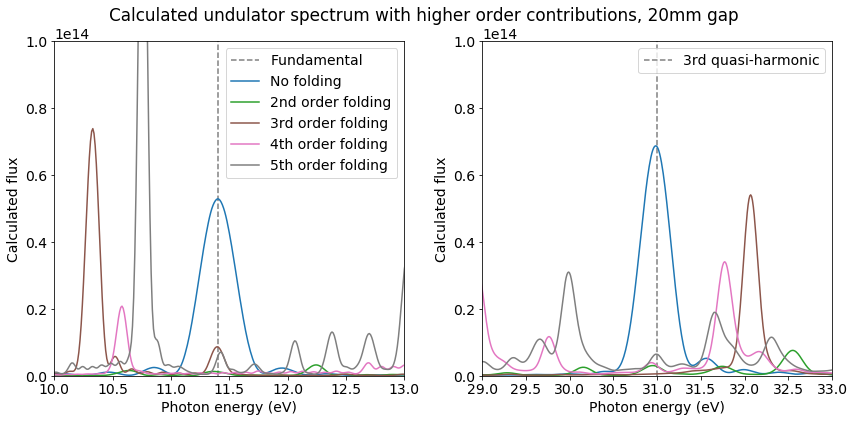

In [125]:
fig=plt.figure(figsize=(12,6))
fig.suptitle("Calculated undulator spectrum with higher order contributions, 20mm gap")
plt.subplot(1, 2, 1)
plt.plot([11.4,11.4],[0,1e14],linestyle='--',color='grey',label="Fundamental")
plt.plot(calculation['mono_energy'],calculation['flux'],color='tab:blue',label="No folding")
plt.plot(calculation['mono_energy'],calculation['current_2ndOrder_toFlux'],color='tab:green',label="2nd order folding")
plt.plot(calculation['mono_energy'],calculation['current_3rdOrder_toFlux'],color='tab:brown',label="3rd order folding")
plt.plot(calculation['mono_energy'],calculation['current_4thOrder_toFlux'],color='tab:pink',label="4th order folding")
plt.plot(calculation['mono_energy'],calculation['current_5thOrder_toFlux'],color='tab:gray',label="5th order folding")
plt.xlabel('Photon energy (eV)')
plt.ylabel('Calculated flux')
plt.ylim([0,1e14])
plt.xlim([10,13])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([31,31],[0,1e14],linestyle='--',color='grey',label="3rd quasi-harmonic")
plt.plot(calculation['mono_energy'],calculation['flux'],color='tab:blue')
plt.plot(calculation['mono_energy'],calculation['current_2ndOrder_toFlux'],color='tab:green')
plt.plot(calculation['mono_energy'],calculation['current_3rdOrder_toFlux'],color='tab:brown')
plt.plot(calculation['mono_energy'],calculation['current_4thOrder_toFlux'],color='tab:pink')
plt.plot(calculation['mono_energy'],calculation['current_5thOrder_toFlux'],color='tab:gray')
plt.xlabel('Photon energy (eV)')
plt.ylabel('Calculated flux')
plt.ylim([0,1e14])
plt.xlim([29,33])
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Gold mesh versus diode

Actually there is one trick that can give something approximating energy resolution. The same spectrum can be measured using the gold mesh or the photodiode as a detector. 

The photodiode response scales approximately linearly (I=k\*hv, k=0.27) with photon energy. I don't know the mesh response yet, but I believe that it's much flatter than this with respect to energy.

This means that if a given peak is much larger in the photodiode spectrum than in the gold mesh spectrum, it is probably made up of higher-order photons.

Let's see if that idea works:

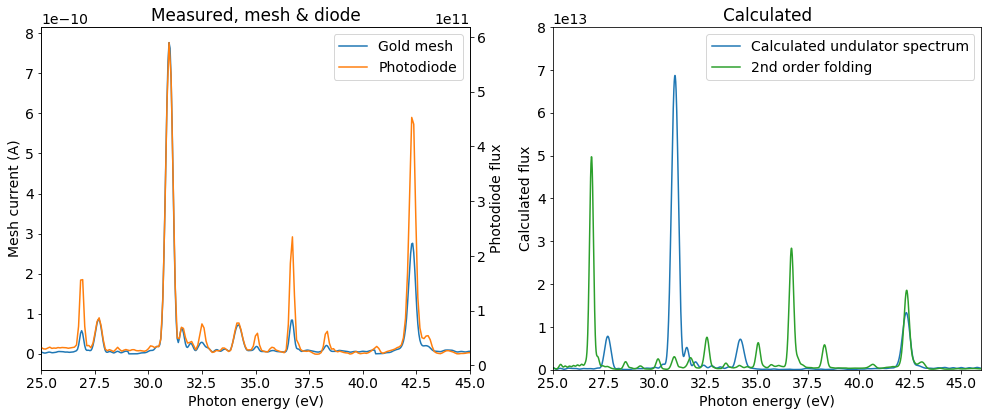

In [122]:
fig=plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()
trace1=ax1.plot(goldMesh['mono_energy_calibrated'],goldMesh['Current'],label='Gold mesh')
trace2=ax2.plot(photoDiode['mono_energy_calibrated'],photoDiode['flux'],color='tab:orange',label='Photodiode')
ax1.set_ylabel('Mesh current (A)')
ax2.set_ylabel('Photodiode flux')
ax1.set_xlim([25,45])
traces = trace1 + trace2
labels = [trace.get_label() for trace in traces]
ax2.legend(traces,labels)
plt.title('Measured, mesh & diode')
ax1.set_xlabel('Photon energy (eV)')

plt.subplot(1, 2, 2)
plt.plot(calculation['mono_energy'],calculation['flux'],color='tab:blue',label="Calculated undulator spectrum")
plt.plot(calculation['mono_energy'],calculation['current_2ndOrder_toFlux'],color='tab:green',label="2nd order folding")
plt.ylabel('Calculated flux')
plt.xlabel('Photon energy (eV)')
plt.ylim([0,8e13])
plt.xlim([25,46])
plt.title('Calculated')
plt.legend()
plt.tight_layout()
plt.show()

**It seems to work**: When plotted this way, the 'real' peaks at 27.7eV, 30.1eV and 34.2eV have similar intensities for the gold mesh and for the photodiode. 

Peaks which we believe have a strong higher-order component are more intense in the photodiode than in the mesh, betraying their higher-energy nature.

***
***